## Problem Statement and Hypothesis:

SF rents have been steadily rising since 2000 to 2010 when 28,500 newcomers arrived to the city. From 2010-2012, 20,600 additional people moved in, in just three years. People have attributed the growth of population to the blazing technology sector. 

While the demand for housing increased, supply was relatiively fixed due to zoning laws. The most fundamental rule of economics dictates that prices rise when there is a high demand but low supply. I was interested in seeing how crime affects prices in certain neighbourhoods and if there was a relation between price and crime.

To complete this goal I analyzed trends of reported crime and rent hikes in different neighborhoods and reported trends with exploratory graphs. Predict prices of housing in San Francisco using districts, years, bedrooms, and aggregate crime counts per district per year. Use Regression, CART, Random Forests to predict rental prices based on variables such as categorized crime counts, bedrooms, and year. 

In [1]:
import pandas as pd
import numpy as np
import shapely

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Description of Data: 

The project involves an in depth analysis of the change of rental and crime rates in San Francisco from 2003-2015. Data was retrieved from a multitude of sources but mainly Eric Fischers github repo of aggregated Craigslist rental data archived from wayback machine and the SF crime data set from opendata.

Original data from craigslist appears as below, and I needed to parse and extract attributes specifically price, bedrooms, and district. This task was performed through a variety of data structure methods and regular expressions.

![alttext](https://snag.gy/c6B3eQ.jpg)

## Variable Engineering:

Variables were obtained from the craigslist data and locations of districts were scraped from Google. The rest of the variables were present in the crime dataset. Engineered a few features based on whether a crime was violent, alcohol related, organized, narcotic, or city related.



In [3]:
#crime = pd.read_csv('./train.csv')    # read in crime
crime = pd.read_csv('./SFPD_Incidents_-_from_1_January_2003.csv')
crime_sub = crime.sample(100000)   #subset sample
crime_sub.head(1)


IncidntNum  Category        Descript DayOfWeek        Date   Time  \
1399038   101001884  WARRANTS  WARRANT ARREST  Thursday  10/28/2010  11:02   

        PdDistrict      Resolution              Address           X  \
1399038       PARK  ARREST, BOOKED  SCOTT ST / LLOYD ST -122.435054   

                 Y                               Location            PdId  
1399038  37.769897  (37.7698968941871, -122.435054154915)  10100188463010

In [2]:
district_coordinates = pd.read_csv('./district_coordinates.csv')   # read in coordinates
del district_coordinates['Unnamed: 0']
district_coordinates = district_coordinates.dropna()
district_coordinates.head()  # 4 coordinate places is an accuracy of 11 meters

district      lat       lon
0      bernal heights  37.7412 -122.4178
1              castro  37.7609 -122.4350
2           chinatown  37.7941 -122.4078
4           excelsior  37.7244 -122.4272
5  financial district  37.7946 -122.3999

![alt text](https://snag.gy/drov4h.jpg)

![alt text](https://snag.gy/iueFGt.jpg)

![alt text](https://snag.gy/JhSIeD.jpg)

![alt text](https://snag.gy/FBvsql.jpg)

![alt text](https://snag.gy/VBGKnm.jpg)

![alt text](https://snag.gy/MaqYbw.jpg)

![alt text](https://snag.gy/sme2St.jpg)

![alt text](https://snag.gy/qd04hF.jpg)

![alt text](https://snag.gy/ul3FW8.jpg)

![alt text](https://snag.gy/R9aHBN.jpg)

![alt text](https://snag.gy/UJkSVe.jpg)

In [ ]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')

price_by_hood_pre = posts_crimes[posts_crimes.bed == 1]
price_by_hood = pd.DataFrame(price_by_hood_pre.groupby(['district1','year']).median()['price']).reset_index()

price_by_hood[price_by_hood.year == (2003)].groupby(['district1','year']).median().sort_values('price').plot(kind = 'barh', color = 'black')

price_by_hood[price_by_hood.year == (2015)].groupby(['district1','year']).median().sort_values('price').plot(kind = 'barh', color = 'black')

# Function to map crime location coordinates to districts

In [4]:
# get decimals as a feature X1 X2 from the location coordinates
from decimal import Decimal
def replace_lon(location):
    
    lon = str(location).replace('(','').replace(')','').split(',')
    lon = np.float64(lon[1])
    return lon
    
def replace_lat(location):
    lat = str(location).replace('(','').replace(')','').split(',')
    lat = np.float64(lat[0])
    return lat
    
crime_sub['X1'] = crime_sub.apply(lambda row: replace_lon(row['Location']),axis = 1)
crime_sub['Y1'] = crime_sub.apply(lambda row: replace_lat(row['Location']),axis = 1)

# haversine distances to check which crime occured in what district
%timeit
from haversine import haversine
def check_distance(location):
    #print location
    haversine_list = []
    for d,lat,lon in zip(district_coordinates.district,district_coordinates.lat, district_coordinates.lon):

        haversine_list.append((haversine(location, (lon,lat)),d))
    
    match = sorted(haversine_list)[0][1]
    return match
    
crime_sub['match_district'] = crime_sub.apply(lambda row: check_distance((row['X1'],row['Y1'])), axis = 1 )

In [5]:
# create crime Categories
crime_sub.Category.value_counts()

theft = ['LARCENY/THEFT','VEHICLE THEFT','BURGLARY','ROBBERY','STOLEN PROPERTY','RECOVERED VEHICLE']
drunk = ['DRUG/NARCOTIC','DRUNKENNESS','LIQOUR LAWS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']
organized = ['BRIBERY','EXTORTION','PROSTITUTION']
violent = ['ASSAULT','SEX OFFENSES, FORCIBLE','KIDNAPPING']
narcotic = ['DRUG/NARCOTIC']
city = ['VANDALISM','LOITERING']

crime_sub['is_theft'] = crime_sub.Category.apply(lambda x: 1 if x in theft else 0)
crime_sub['is_drunk'] = crime_sub.Category.apply(lambda x: 1 if x in drunk else 0)
crime_sub['is_organized'] = crime_sub.Category.apply(lambda x: 1 if x in organized else 0)
crime_sub['is_violent'] = crime_sub.Category.apply(lambda x: 1 if x in violent else 0)
crime_sub['is_narcotic'] = crime_sub.Category.apply(lambda x: 1 if x in narcotic else 0)
crime_sub['is_city'] = crime_sub.Category.apply(lambda x: 1 if x in city else 0)

## Convert indexes and dates to datetime

In [6]:
from datetime import datetime as dt
print crime_sub.index.dtype
crime_sub['Date'] = pd.to_datetime(crime_sub['Date'])
crime_sub.set_index('Date',inplace= True)
print crime_sub.index.dtype

# create a year function, 2016 is not completely represented
crime_sub['year'] = crime_sub.index.map(lambda val: val.year)
crime_sub.head(1)
crime_sub = crime_sub[crime_sub['year'] < 2016]

int64
datetime64[ns]


In [7]:
posts = pd.read_csv('./craigslist_posts.csv')
posts.head()
posts = posts[posts.bed < 6]

## Transformations

In [8]:
crime_groups = pd.DataFrame(crime_sub.groupby(['year','Category','match_district']).size())

crime_wide = crime_groups.reset_index()
crime_wide.head()

crime_wide.columns = ['year','crime','district','crime_count']
crime_wide.head()

print [x for x in crime_wide.district.values if not type(x) == str]

crime_wide = crime_wide[[True if type(x) == str else False for x in crime_wide.district.values]]

crime_wide.district = crime_wide.district.map(lambda x: x.lower())
crime_wide_ = pd.pivot_table(crime_wide, index=['year','crime'], columns=['district'], fill_value=0)['crime_count'].reset_index()
crime_wide_.head()

crime_trans = crime_wide.T

posts = posts.iloc[:,1:]
posts.head()

crime_trans.columns = np.ravel(crime_trans.ix['crime',:].values)
crime_trans.head()

small_posts = posts

small_posts.shape

small_posts.year.value_counts()

[]


2005    15455
2004     6433
2006     4529
2016     2494
2012     2283
2014     2218
2015     2030
2011     1476
2007      884
2013      772
2003      497
2008      487
2009      195
2010       99
Name: year, dtype: int64

In [ ]:
posts_crimes.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder

posts_crimes.district1 = posts_crimes.district1.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district2 = posts_crimes.district2.map(lambda x: 'none' if x == 0 else x)
posts_crimes.district3 = posts_crimes.district3.map(lambda x: 'none' if x == 0 else x)

label_encoder = LabelEncoder()

dists = posts_crimes.district1.values.tolist() + posts_crimes.district2.values.tolist() + posts_crimes.district3.values.tolist()
dists = np.unique(dists)
# print dists
# print posts_crimes.district1.unique()
# print posts_crimes.district2.unique()
# print posts_crimes.district3.unique()


label_encoder.fit(dists)

posts_crimes['district1_code'] = label_encoder.transform(posts_crimes.district1.values)
posts_crimes['district2_code'] = label_encoder.transform(posts_crimes.district2.values)
posts_crimes['district3_code'] = label_encoder.transform(posts_crimes.district3.values)

In [ ]:

posts_crimes.to_csv('./aggregate_df.csv')

In [22]:
posts_crimes = pd.read_csv('./aggregate_df.csv')
del posts_crimes['Unnamed: 0']

In [78]:
posts_crimes.head(1)

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        bed  district1  district2  \
0               0                1       ...          1     sunset   parkside   

      district3                                               post  price  \
0  inner sunset  950  1br  sunny one bedroom for rent sunset  p...  950.0   

   year  district1_code  district2_code  district3_code  
0  2003              45              36              14  

[1 rows x 124 columns]

In [45]:
posts_crimes = posts_crimes[posts_crimes.price < 50000]

In [46]:
target = posts_crimes.price
tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object or col == 'district1']]

print posts_crimes.post.dtype

object


In [47]:
tmp.head()

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   
1         0           7              0           0            5   
2         1          37              1           0           10   
3         1          16              0           0           12   
4         1          12              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   
1                      0                               1                 1   
2                      4                               1                34   
3                      2                               0                 3   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        D3_VEHICLE THEFT  \
0               0                1       ...                      17   
1               2                0       ...                       0   
2               1                2       ...                      57   
3               1                0       ...                      24   
4               1                0       ...                      17   

   D3_WARRANTS  D3_WEAPON LAWS  bed        district1   price  year  \
0            0               1    1           sunset   950.0  2003   
1            0               0    2           marina  1500.0  2003   
2           22               6    2     hayes valley  1795.0  2003   
3            7               0    0  pacific heights  1180.0  2003   
4            0               1    1   inner richmond  1100.0  2003   

   district1_code  district2_code  district3_code  
0              45              36              14  
1              21              27              27  
2              11              28              51  
3              33              40              13  
4              13              32              14  

[5 rows x 121 columns]

In [48]:
bigml = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code','district1','price']
bigml = tmp[bigml]
bigml.to_csv('bigml.csv')

In [49]:
#pd.read_csv('./bigml.csv')

In [50]:
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1_code']
tmp[D1].head()

D1_ARSON  D1_ASSAULT  D1_BAD CHECKS  D1_BRIBERY  D1_BURGLARY  \
0         0           9              0           0            4   
1         0           7              0           0            5   
2         1          37              1           0           10   
3         1          16              0           0           12   
4         1          12              0           0            6   

   D1_DISORDERLY CONDUCT  D1_DRIVING UNDER THE INFLUENCE  D1_DRUG/NARCOTIC  \
0                      1                               0                 1   
1                      0                               1                 1   
2                      4                               1                34   
3                      2                               0                 3   
4                      0                               0                 4   

   D1_DRUNKENNESS  D1_EMBEZZLEMENT       ...        D1_SUICIDE  \
0               0                1       ...                 0   
1               2                0       ...                 0   
2               1                2       ...                 0   
3               1                0       ...                 0   
4               1                0       ...                 1   

   D1_SUSPICIOUS OCC  D1_TRESPASS  D1_VANDALISM  D1_VEHICLE THEFT  \
0                  4            0            13                 7   
1                  1            0             7                13   
2                  9            8            21                37   
3                  4            2             7                18   
4                  9            3             5                24   

   D1_WARRANTS  D1_WEAPON LAWS  bed  year  district1_code  
0            1               1    1  2003              45  
1            1               1    2  2003              21  
2           30               3    2  2003              11  
3            0               0    0  2003              33  
4            7               0    1  2003              13  

[5 rows x 41 columns]

In [51]:
district_codes_df = tmp[D1]['district1_code']

In [52]:
district_codes_df.head()

0    45
1    21
2    11
3    33
4    13
Name: district1_code, dtype: int64

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

X = tmp[D1]
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

lm = LinearRegression()

model = lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)
print model.score(X_test, y_test)   # coefficient of r2
print model.score(X_test,y_pred)


0.436760175391
1.0


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


param_grid = {'max_depth': np.arange(3, 10),'min_samples_split':[2,5,10]}

tree = GridSearchCV(DecisionTreeRegressor(criterion='mse'), param_grid, cv = 10,n_jobs = -1)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print tree_performance
print tree.best_params_
print tree.grid_scores_
print tree.best_estimator_
print tree.best_score_


(13143, 41) (13143,)
[ 1176.11030741  3651.77852349  1284.23255814 ...,  4393.42857143
  2324.56382979  1176.11030741]
0.601647702381
{'min_samples_split': 10, 'max_depth': 9}
[mean: 0.39109, std: 0.03731, params: {'min_samples_split': 2, 'max_depth': 3}, mean: 0.39109, std: 0.03731, params: {'min_samples_split': 5, 'max_depth': 3}, mean: 0.39109, std: 0.03731, params: {'min_samples_split': 10, 'max_depth': 3}, mean: 0.42581, std: 0.03629, params: {'min_samples_split': 2, 'max_depth': 4}, mean: 0.42581, std: 0.03629, params: {'min_samples_split': 5, 'max_depth': 4}, mean: 0.42581, std: 0.03629, params: {'min_samples_split': 10, 'max_depth': 4}, mean: 0.47645, std: 0.03995, params: {'min_samples_split': 2, 'max_depth': 5}, mean: 0.47645, std: 0.03995, params: {'min_samples_split': 5, 'max_depth': 5}, mean: 0.47645, std: 0.03995, params: {'min_samples_split': 10, 'max_depth': 5}, mean: 0.51410, std: 0.04681, params: {'min_samples_split': 2, 'max_depth': 6}, mean: 0.51445, std: 0.04683, p

(13143, 41) (13143,)
[ 2503.45360825  2238.33203125  1825.81616482 ...,  1406.57020057
  3401.75675676  6229.77227723]
performance r2: 0.595346137903
[  4.39972363e-04   8.56199395e-03   2.45963749e-05   0.00000000e+00
   1.10209653e-02   1.26189219e-03   1.35558825e-03   8.70530944e-03
   6.96028936e-04   2.12486700e-04   1.49931001e-03   7.23247190e-04
   9.92209070e-04   2.11218025e-03   0.00000000e+00   4.27592234e-04
   8.79271629e-02   2.59861280e-03   5.35741630e-04   3.26983131e-02
   3.76176523e-03   1.50835864e-02   0.00000000e+00   1.75745846e-03
   4.06702154e-03   1.67906348e-03   1.49014387e-06   1.91675498e-02
   1.65348096e-03   3.57770073e-07   2.59949004e-04   0.00000000e+00
   4.64937211e-03   5.83967862e-04   4.92986102e-03   6.39953721e-03
   1.52236465e-03   1.17790736e-03   4.02996560e-01   2.95795695e-01
   7.27198097e-02]


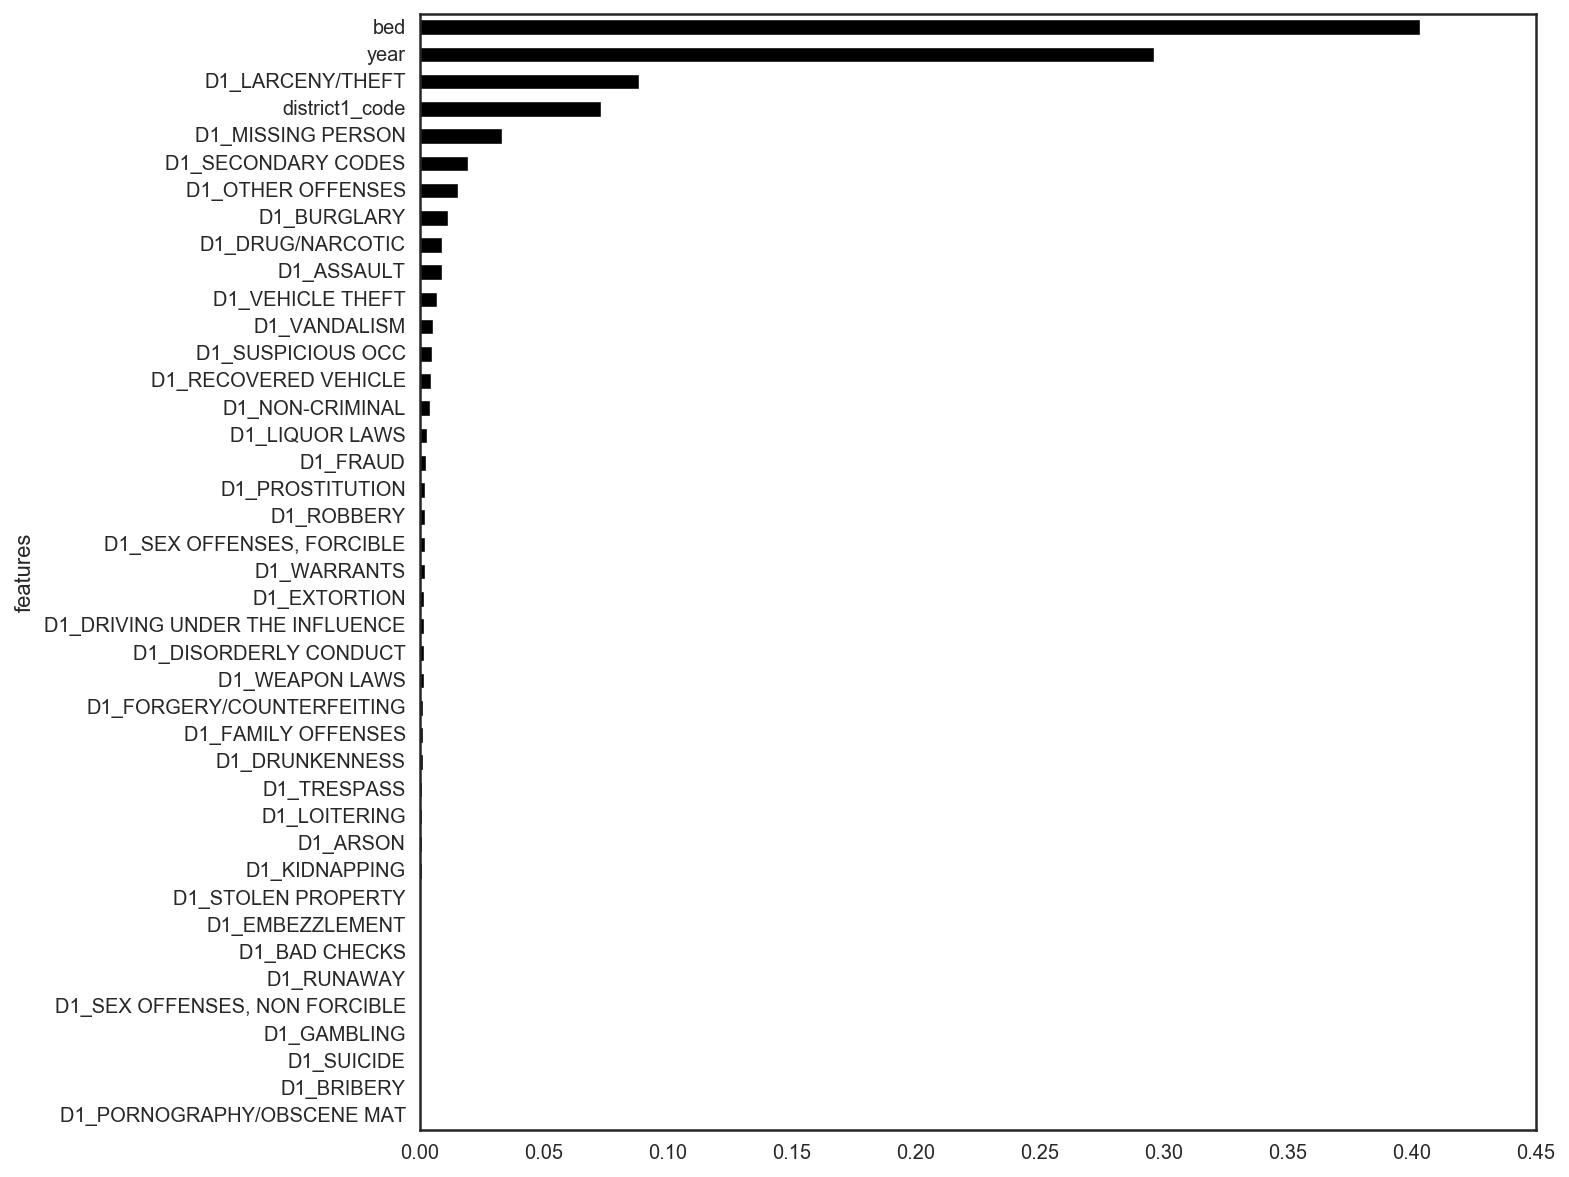

In [55]:

# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape


tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

features_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

sns.set(rc={"figure.figsize": (10,10)})
sns.set_style('white')
features_df.rename(columns = {'index':'score',0:'features'},inplace = True)

features_df.set_index('features').score.sort_values().plot(kind = 'barh', color = 'black')

# 'year','bed','weapon laws',

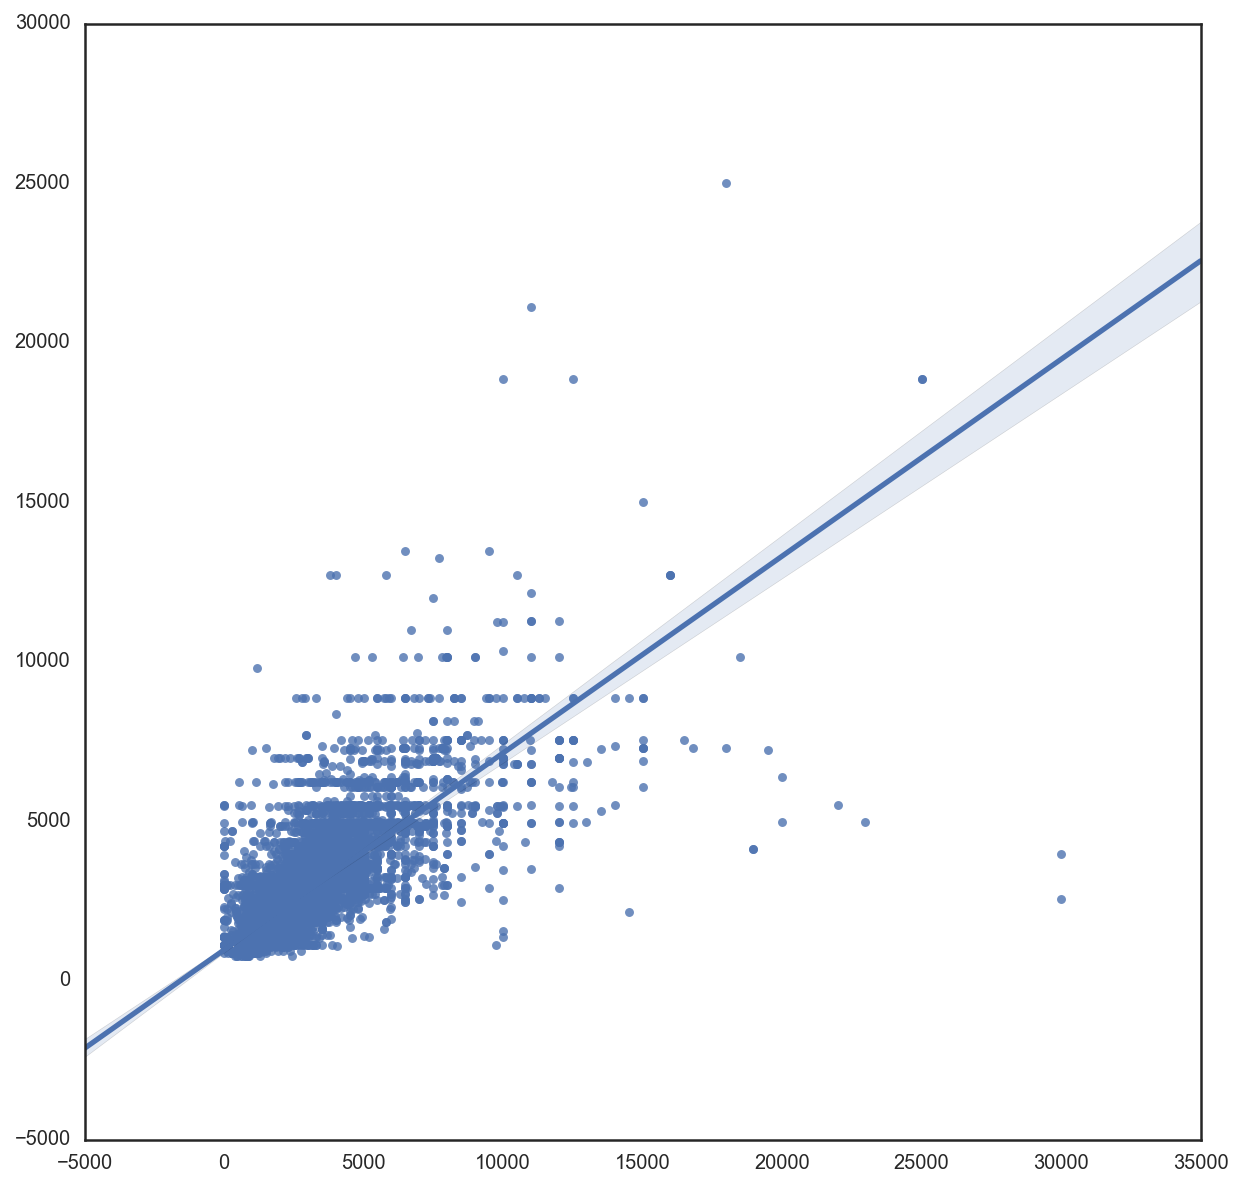

In [58]:
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')
sns.regplot(y_test,tree_preds)

In [33]:
selected_features = [i for i in features_df[features_df.score > .01].features]

# best fit tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree = DecisionTreeRegressor(criterion='mse', max_depth = 9, min_samples_split = 5)

tree.fit(X_train, y_train)

tree_preds = tree.predict(X_test)
print X_test.shape,y_test.shape

print target[0:3]
tree_performance = tree.score(X_test, y_test)

print tree_preds
print 'performance r2:',tree_performance
print tree.feature_importances_

#eatures_df = pd.DataFrame([col for col in tmp[D1]],[i for i in tree.feature_importances_]).reset_index()

(13143, 9) (13143,)
0     950.0
1    1500.0
2    1795.0
Name: price, dtype: float64
[ 2473.96231884  2620.22695035  1764.50359712 ...,  2806.52436975
  5558.92307692  5610.        ]
performance r2: 0.599081446579
[ 0.0308483   0.01784918  0.09806782  0.01806786  0.03011388  0.01948141
  0.41059752  0.2953763   0.07959774]


## Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 3360.44537351  1440.33088279  1820.10540464 ...,  4938.51181095
  1551.07829748  1785.37852407]
forest r2: 0.574853421998
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


performance 0.574853421998


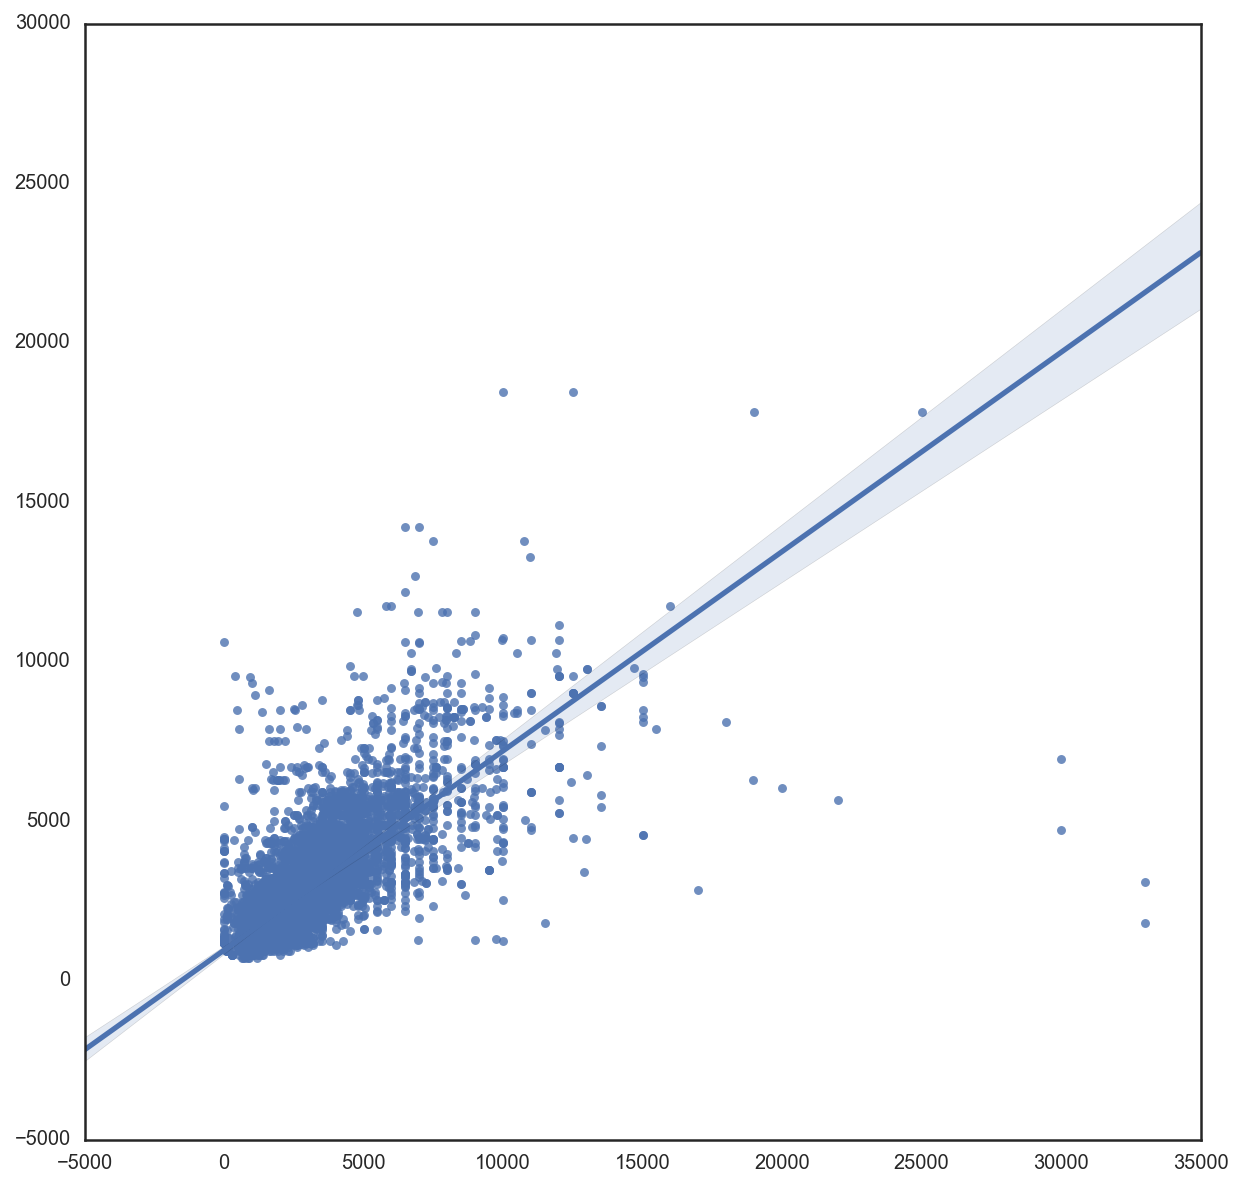

In [63]:
print 'performance', forest_performance
sns.set(rc={"figure.figsize": (10, 10)})
sns.set_style('white')
sns.regplot(y_test,forest_preds)

In [64]:
# random forest selected features

# random forest selected features
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

forest = RandomForestRegressor(random_state=0, n_estimators=1000, min_samples_split = 5)



X_train, X_test, y_train, y_test = train_test_split(tmp[D1][selected_features], target, test_size=0.33)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

forest.fit(X_train, y_train)

forest_preds = forest.predict(X_test)

# forest_preds = cross_val_score(estimator = forest, X_test, y= y_test, scoring=None, cv=5, n_jobs=-1, verbose=0, fit_params=None)

forest_performance = forest.score(X_test, y_test)

print forest_preds
print 'forest r2:',forest_performance
print forest
print forest.get_params

[ 2634.46229774  2274.59509883  1991.6478776  ...,  3963.92108756
  9349.0070456   1616.4868673 ]
forest r2: 0.620942969865
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
<bound method RandomForestRegressor.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)>


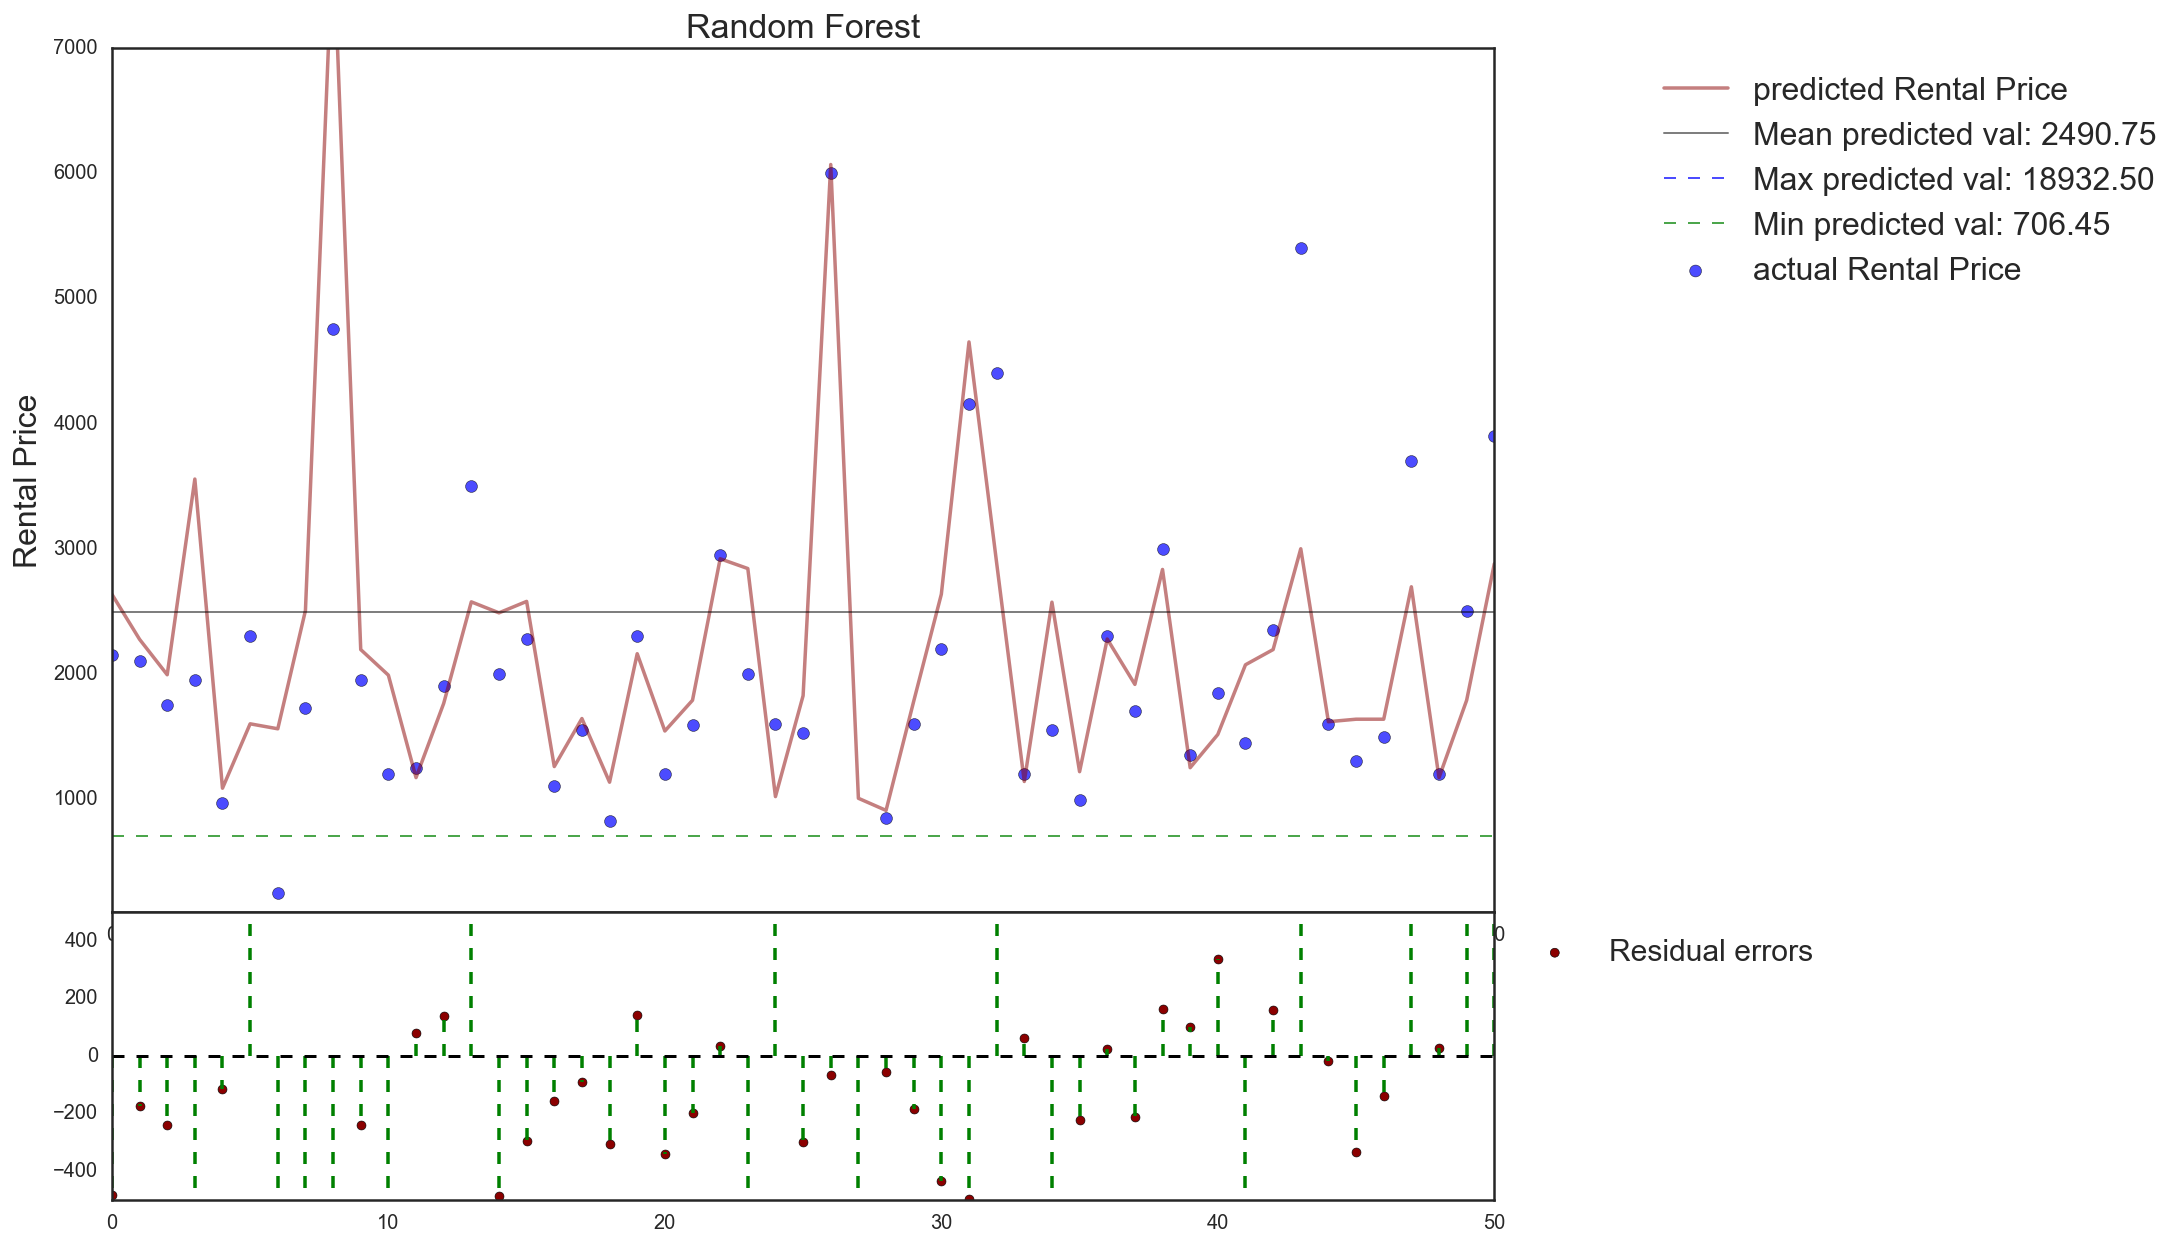

In [72]:
def prediction_plot(pred_array, title, x_limit, actual):
    fig = plt.figure(figsize=(12,10))
    
    frame1=fig.add_axes((.1,.3,.8,.6))
    
    mean_ = np.mean(pred_array)
    min_ = np.min(pred_array)
    max_ = np.max(pred_array)
    ax = fig.gca()
    
    ax.plot(range(len(pred_array)), pred_array, 
               alpha=0.5, c='darkred', label='predicted Rental Price')
    
    ax.scatter(range(len(actual)), actual, s=35,
               alpha=0.7, c='blue', label='actual Rental Price')
    
    zero = ax.axhline(0, lw=1.5, c='black')
    
    mean_line = ax.axhline(mean_, ls='-', lw=1., c='black', alpha=0.5,
                     label='Mean predicted val: %0.2f'%mean_)
              
    max_line = ax.axhline(max_, ls='--', lw=1., c='blue',alpha=0.7, 
               label='Max predicted val: %0.2f'%max_)
    min_line = ax.axhline(min_, ls='--', lw=1., c='green',alpha=0.7,
              label='Min predicted val: %0.2f'%min_)
    
    ax.legend(fontsize=16, bbox_to_anchor=(1.5,1.))
    ax.set_xlim([0,x_limit])
    ax.set_ylim([100,7000])
    ax.set_ylabel('Rental Price', fontsize=16)
    ax.set_title(title, fontsize=17)
    
    #Residual plot box
    residual_error = actual - pred_array
    residual_error = residual_error.tolist()
    
    frame2=fig.add_axes((.1,.1,.8,.2))
    frame2.scatter(range(len(residual_error)), residual_error, c='darkred', label='Residual errors')
    
    
    for i in range(len(residual_error)):
        frame2.plot((i,i),(0,residual_error[i]), ls='--', c='green')
    
    frame2.axhline(0, lw=1.5, c='black', ls='--')
    frame2.set_ylim([-500,500])
    frame2.set_xlim([0,x_limit])
    frame2.legend(bbox_to_anchor=(1.25,1.0), fontsize=15)
    plt.show()
    
    
def plot_list(plot_funtion ,lists, titles, x_limit, actual):
    for i,a in enumerate(lists):
        plot_funtion(a,titles[i], x_limit, actual)
        
plot_list(prediction_plot,[forest_preds], ['Random Forest'], 50, y_test)


In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
features = {}

tmp = posts_crimes[[col for col in posts_crimes if posts_crimes[col].dtype != object or col == 'district1']]
D1 = [c for c in tmp if 'D1' in c ]+['bed','year','district1','price']
group_forest_df = tmp[D1]

for district, group_df in tmp[D1].groupby("district1"):
    try: 
        print district
        target = group_df.price
        predictors = group_df[[col for col in group_df if col not in ['price','district1']]]


        X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33)


        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)

        model = RandomForestRegressor()

        forest = model.fit(X_train, y_train)

        features[district] = forest.feature_importances_
        
    except:
        continue

0
bernal heights
castro
chinatown
downtown
excelsior
financial district
glen park
golden gate park
haight ashbury
hayes valley
ingleside
inner richmond
inner sunset
lakeshore
lincoln park
lone mountain
lower haight
marina
merced
mission bay
mission district
nob hill
noe valley
north beach
oceanview
outer mission
outer richmond
pacific heights
panhandle
parkside
portola
potrero hill
presidio
presidio heights
russian hill
seacliff
south beach
south of market
sunset
tenderloin
treasure island
twin peaks
upper market
usf
visitacion valley
west of twin peaks
western addition


In [74]:
features_df = pd.DataFrame(features).T

In [75]:
features_df.columns = [i for i in predictors.columns]
features_df = features_df.T

In [76]:
features_df.head()

0  bernal heights    castro  chinatown  downtown  excelsior  \
D1_ARSON       0.0    1.380685e-04  0.001030        0.0       0.0        0.0   
D1_ASSAULT     0.0    5.548390e-03  0.021210        0.0       0.0        0.0   
D1_BAD CHECKS  0.0    3.855707e-05  0.000000        0.0       0.0        0.0   
D1_BRIBERY     0.0    9.435765e-07  0.000000        0.0       0.0        0.0   
D1_BURGLARY    0.0    5.518220e-03  0.012229        0.0       0.0        0.0   

               financial district  glen park  golden gate park  \
D1_ARSON                 0.001249   0.000000          0.000000   
D1_ASSAULT               0.023437   0.004414          0.000000   
D1_BAD CHECKS            0.000000   0.000000          0.000000   
D1_BRIBERY               0.000000   0.000000          0.098158   
D1_BURGLARY              0.005138   0.000106          0.000016   

               haight ashbury        ...         south beach  south of market  \
D1_ARSON             0.000555        ...            0.000037         0.012998   
D1_ASSAULT           0.005946        ...            0.001646         0.099880   
D1_BAD CHECKS        0.000000        ...            0.000000         0.014638   
D1_BRIBERY           0.000000        ...            0.000002         0.000000   
D1_BURGLARY          0.009654        ...            0.001877         0.000000   

                 sunset    tenderloin  treasure island  twin peaks  \
D1_ARSON       0.001202  1.795206e-03         0.073683    0.000000   
D1_ASSAULT     0.004544  1.345650e-02         0.000934    0.004874   
D1_BAD CHECKS  0.002163  0.000000e+00         0.000000    0.000087   
D1_BRIBERY     0.000408  7.302500e-07         0.000000    0.000000   
D1_BURGLARY    0.003527  1.512907e-01         0.002119    0.011402   

               upper market       usf  visitacion valley  western addition  
D1_ARSON                0.0  0.000643           0.001478          0.000000  
D1_ASSAULT              0.0  0.000812           0.015599          0.000905  
D1_BAD CHECKS           0.0  0.000000           0.000000          0.000000  
D1_BRIBERY              0.0  0.000080           0.000095          0.001060  
D1_BURGLARY             0.0  0.004101           0.000000          0.009903  

[5 rows x 45 columns]

mission district
south of market
marina
russian hill
north beach
tenderloin


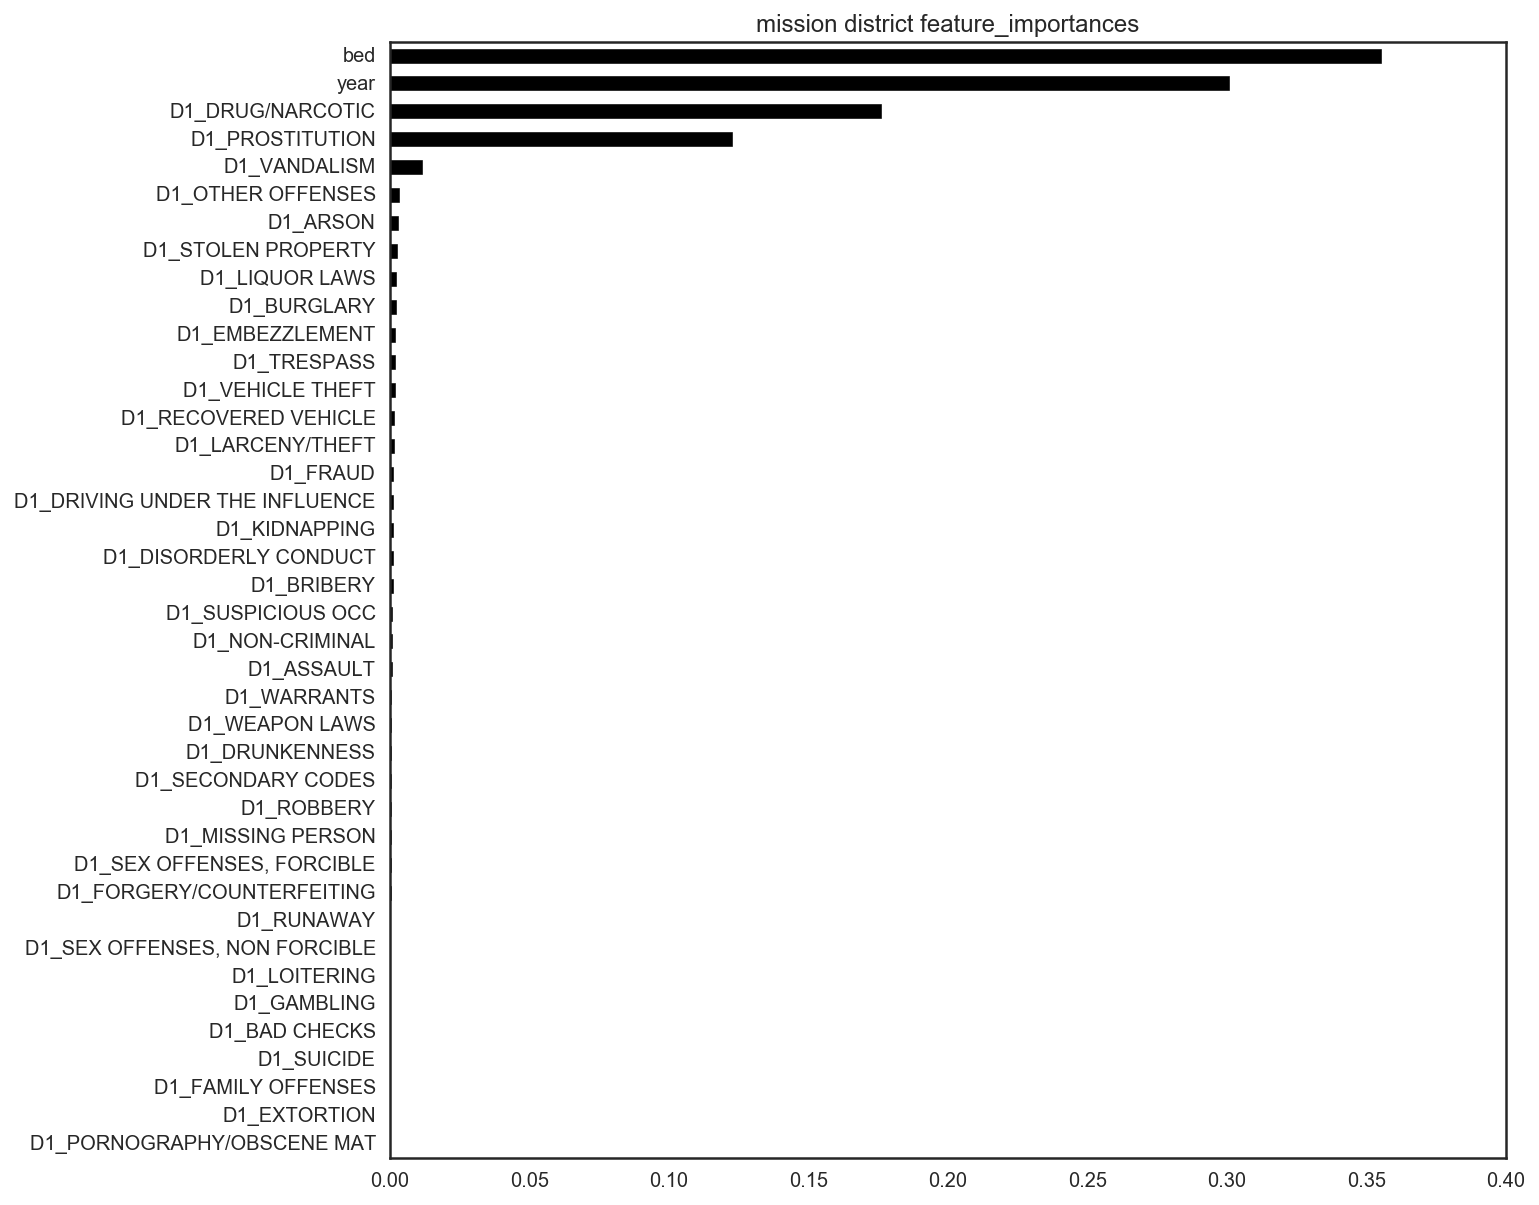

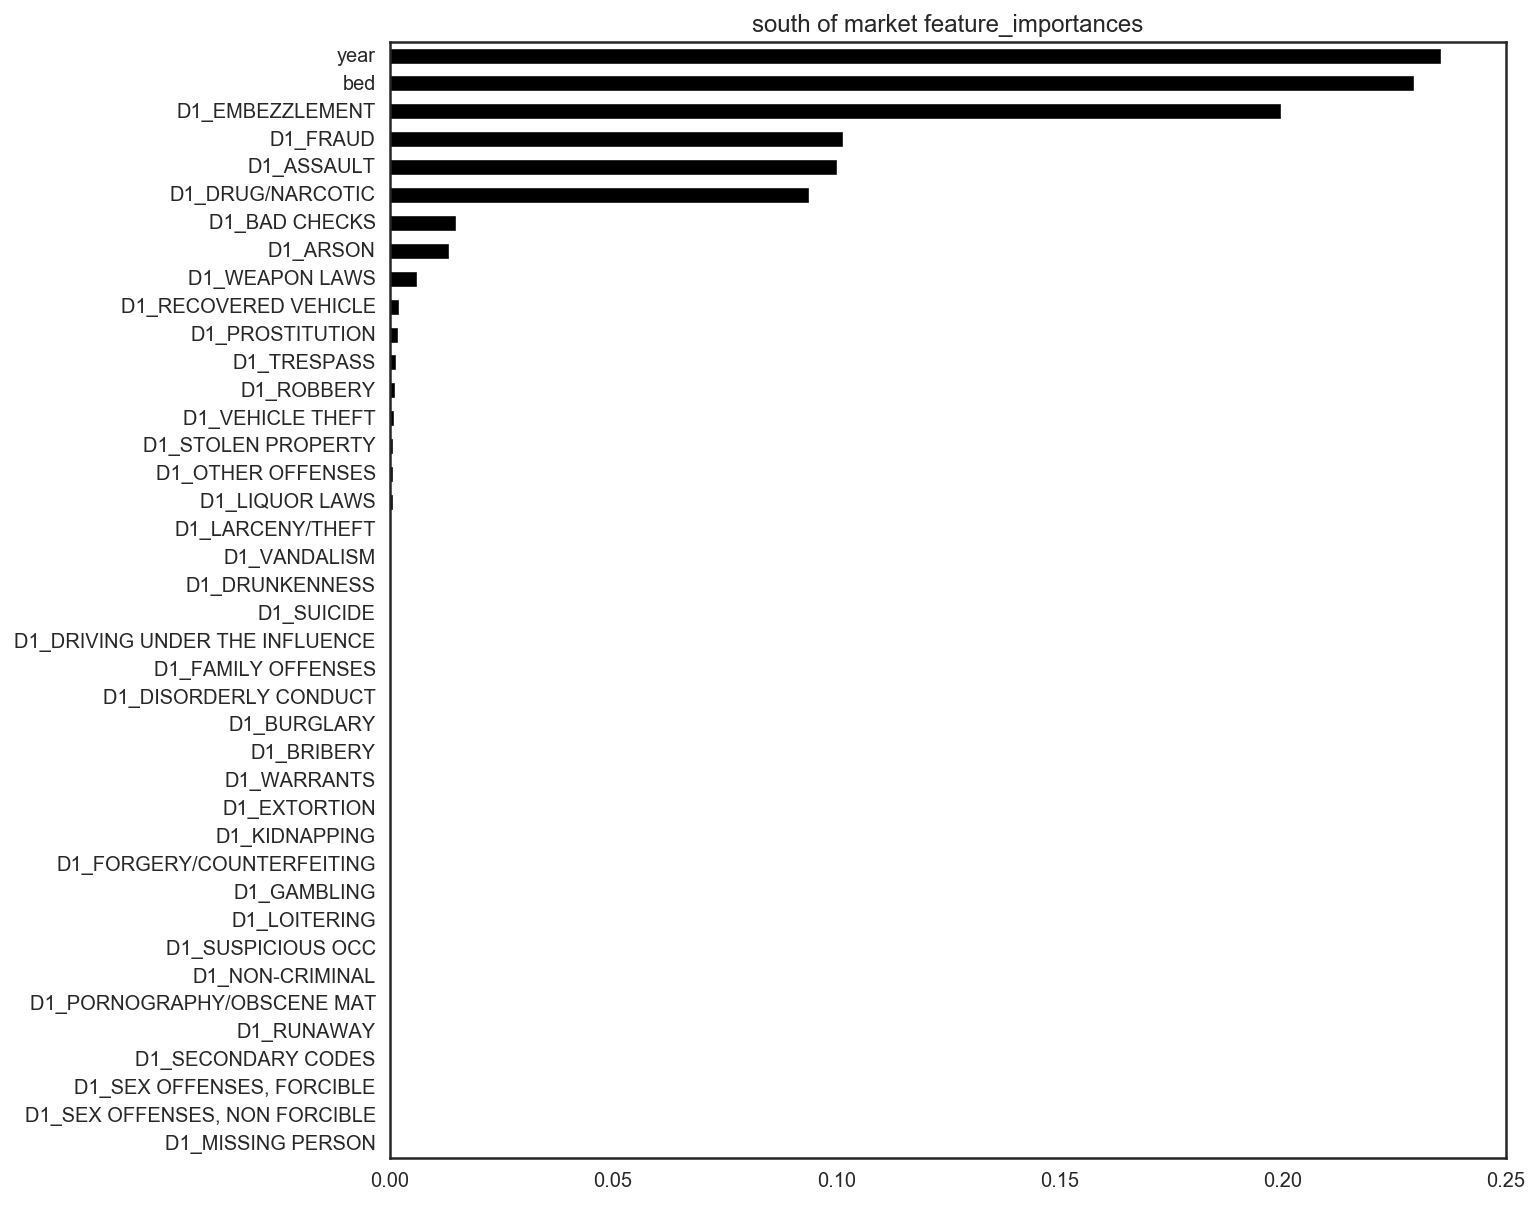

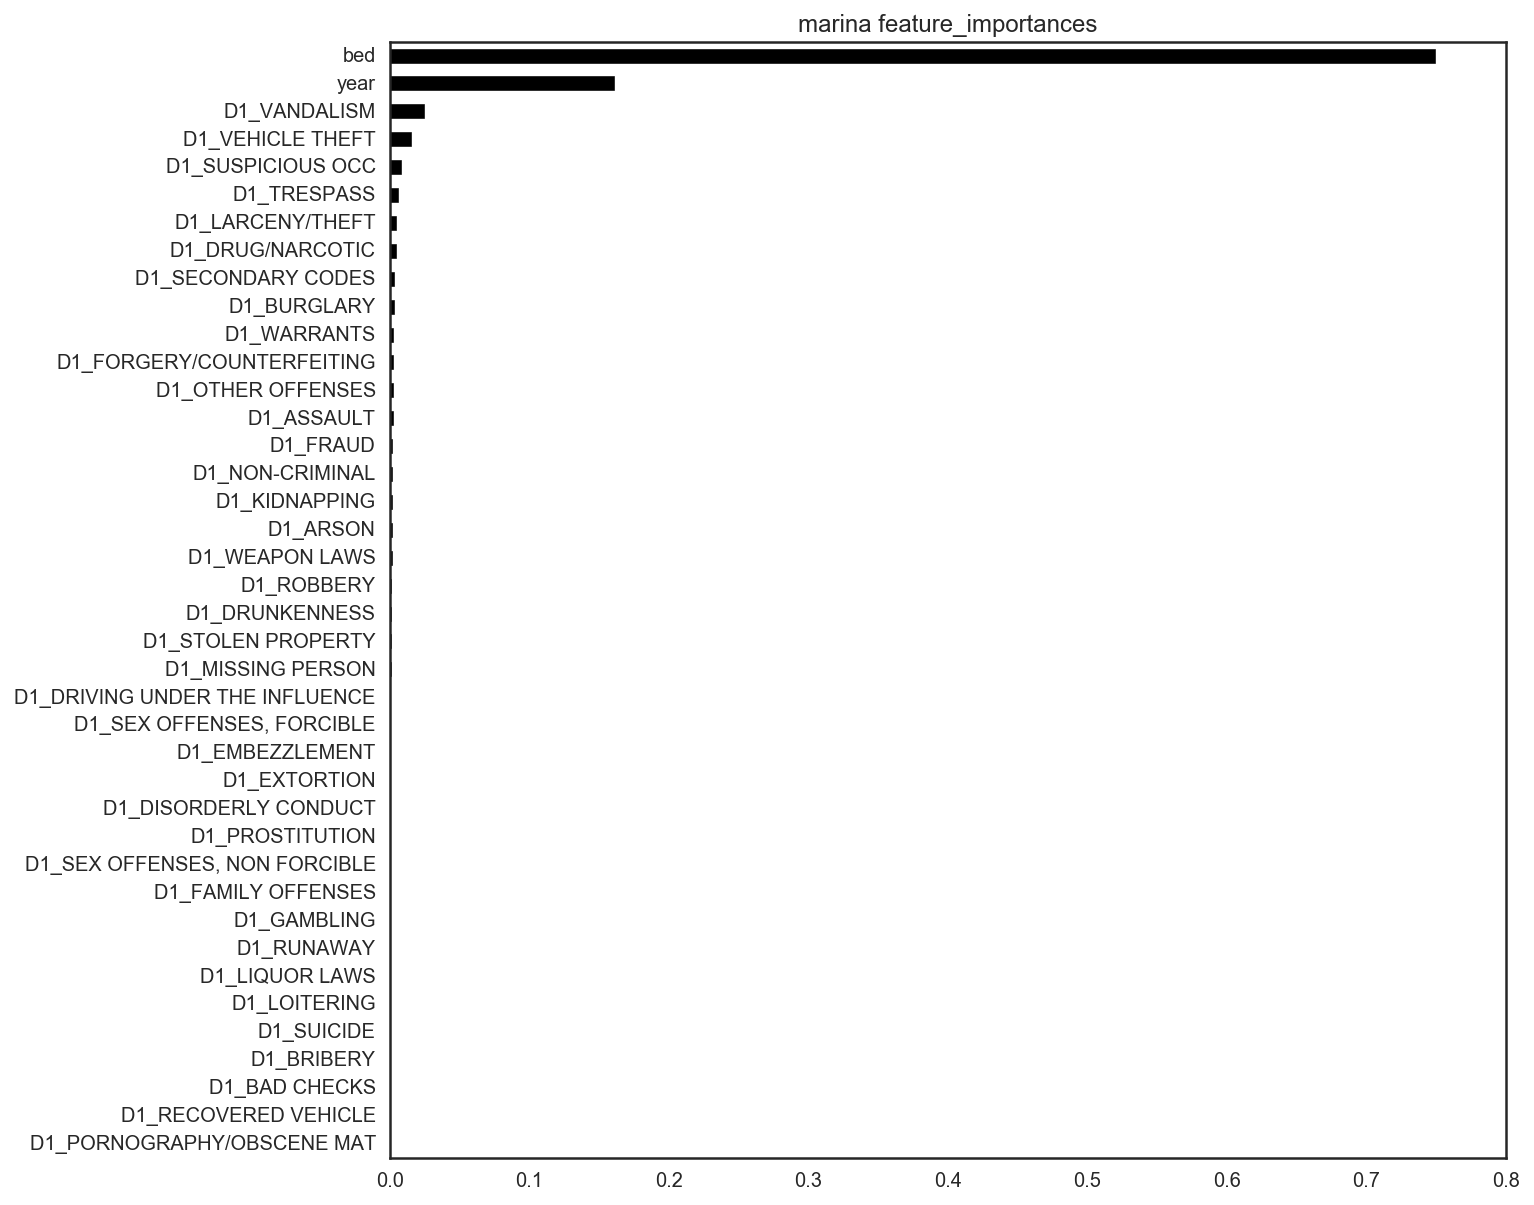

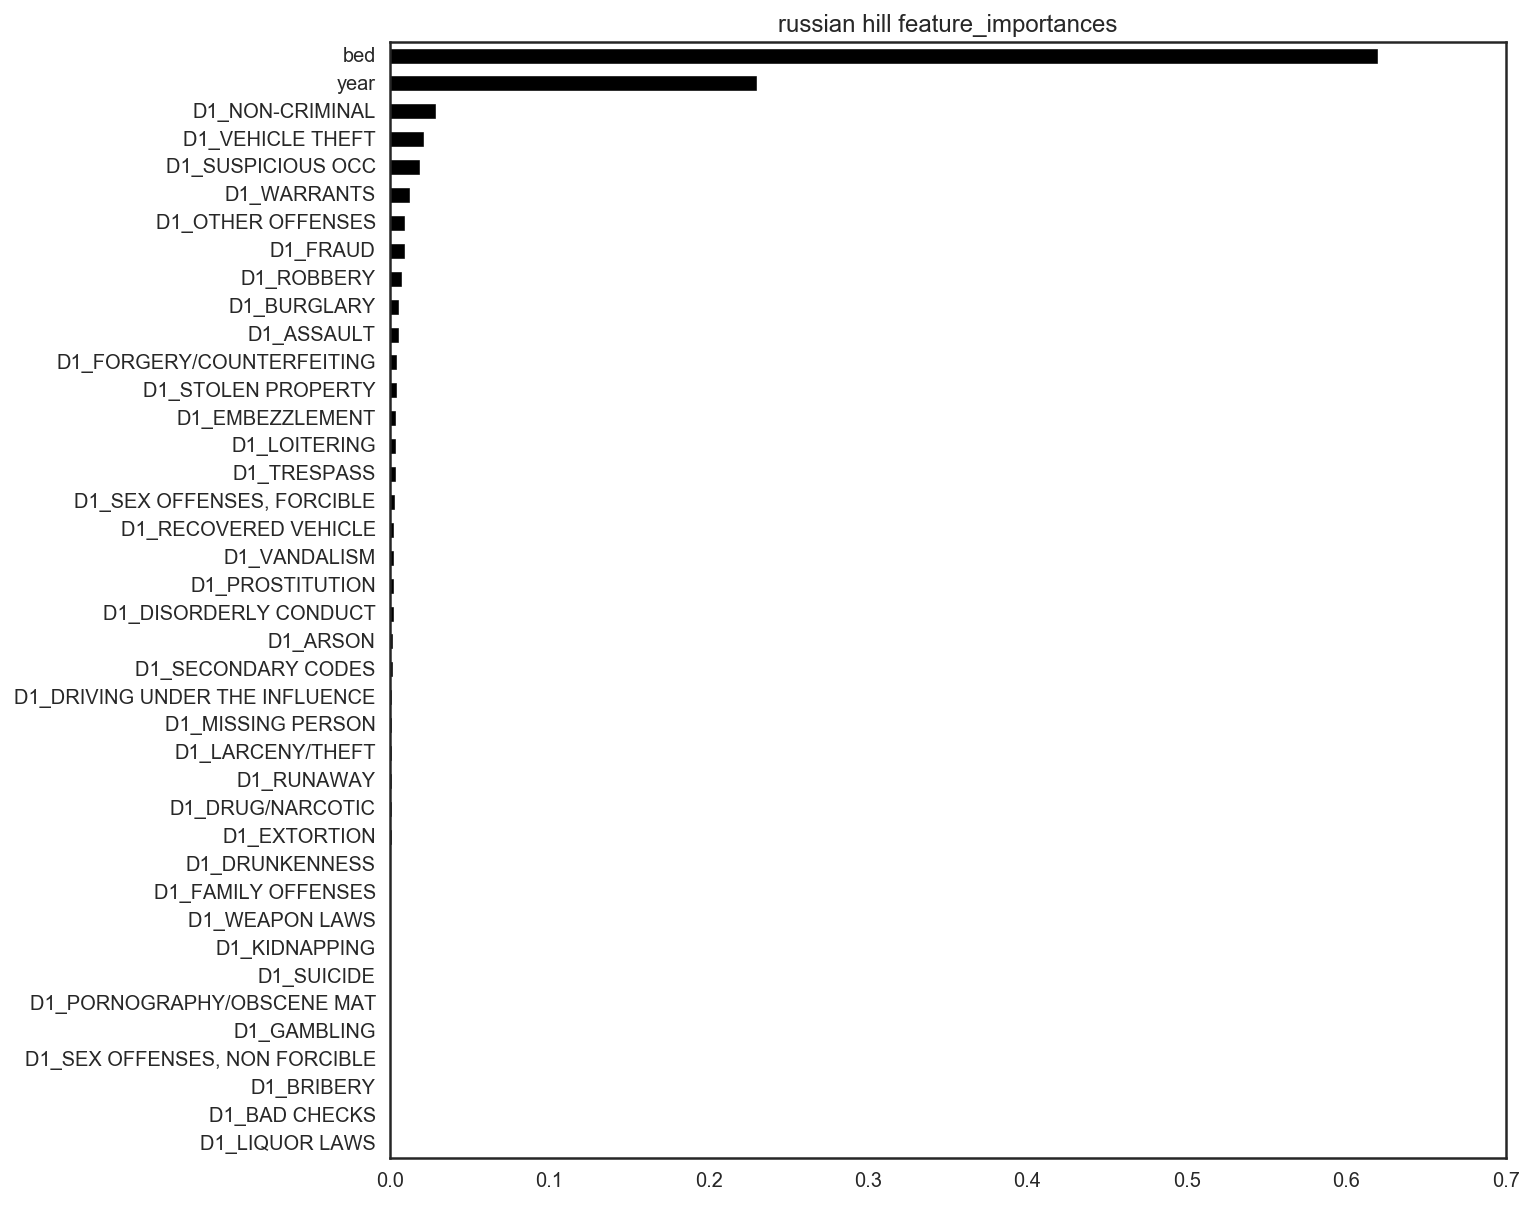

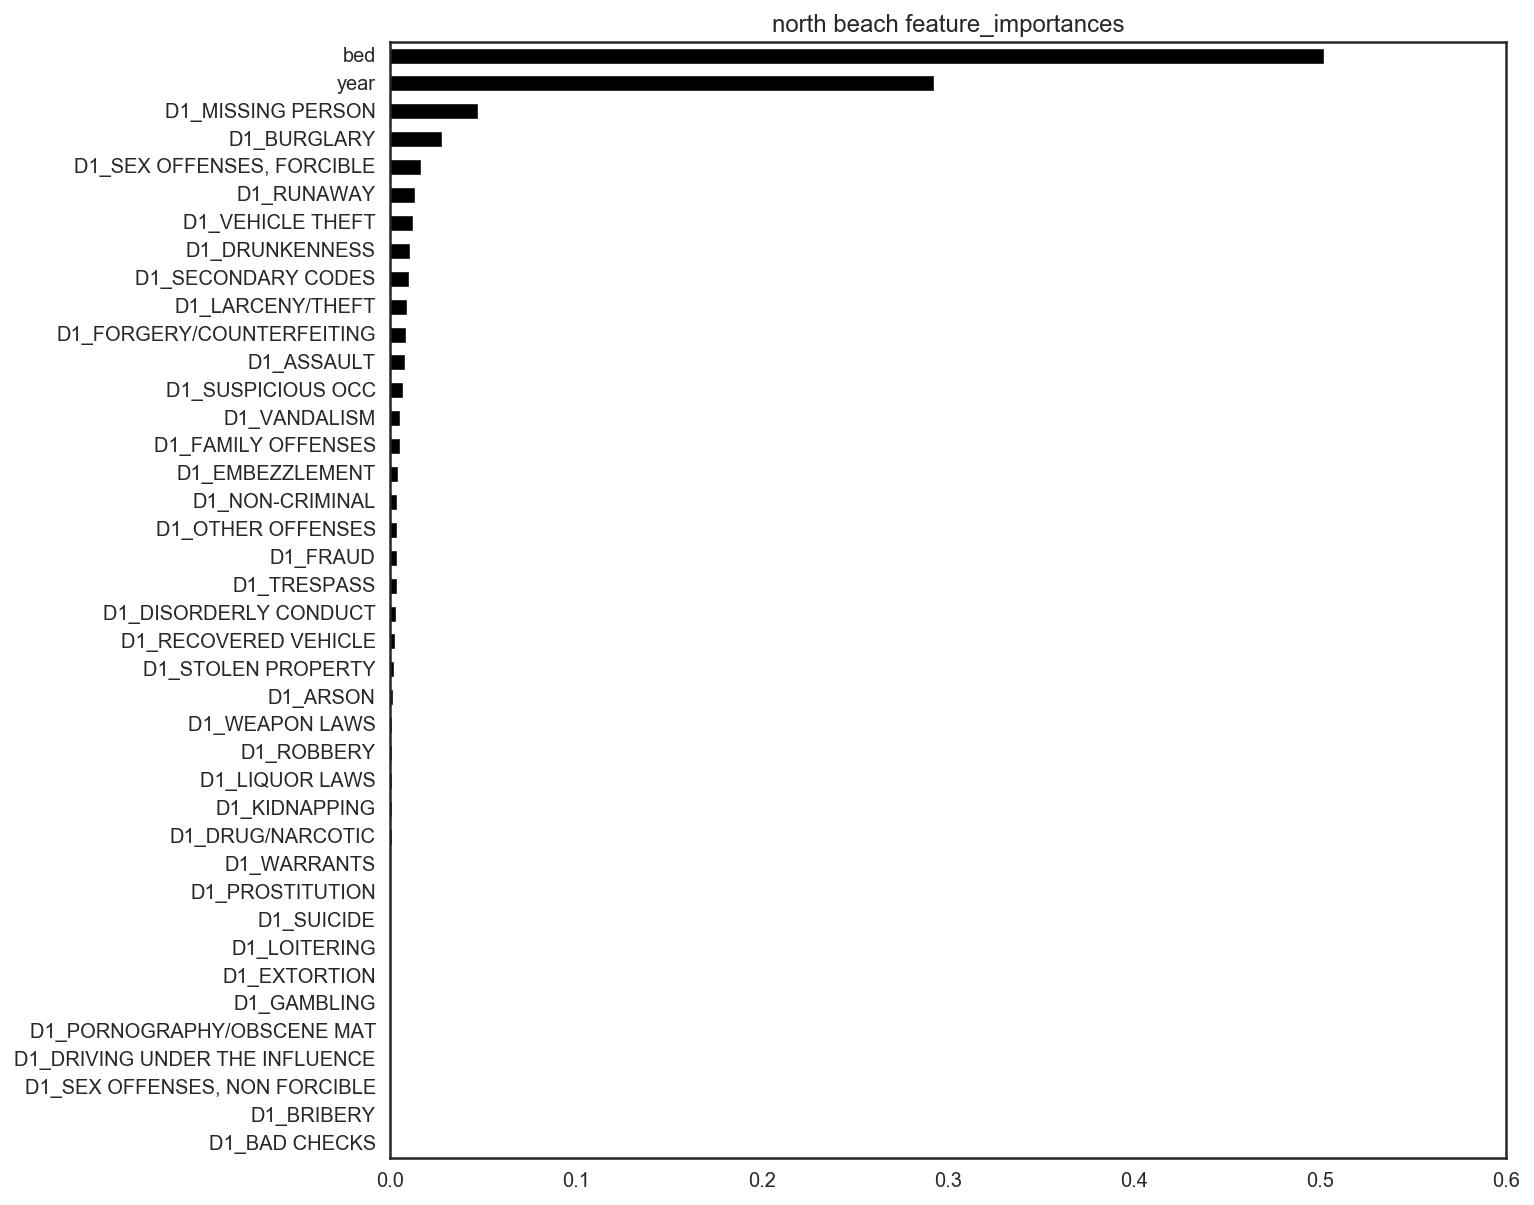

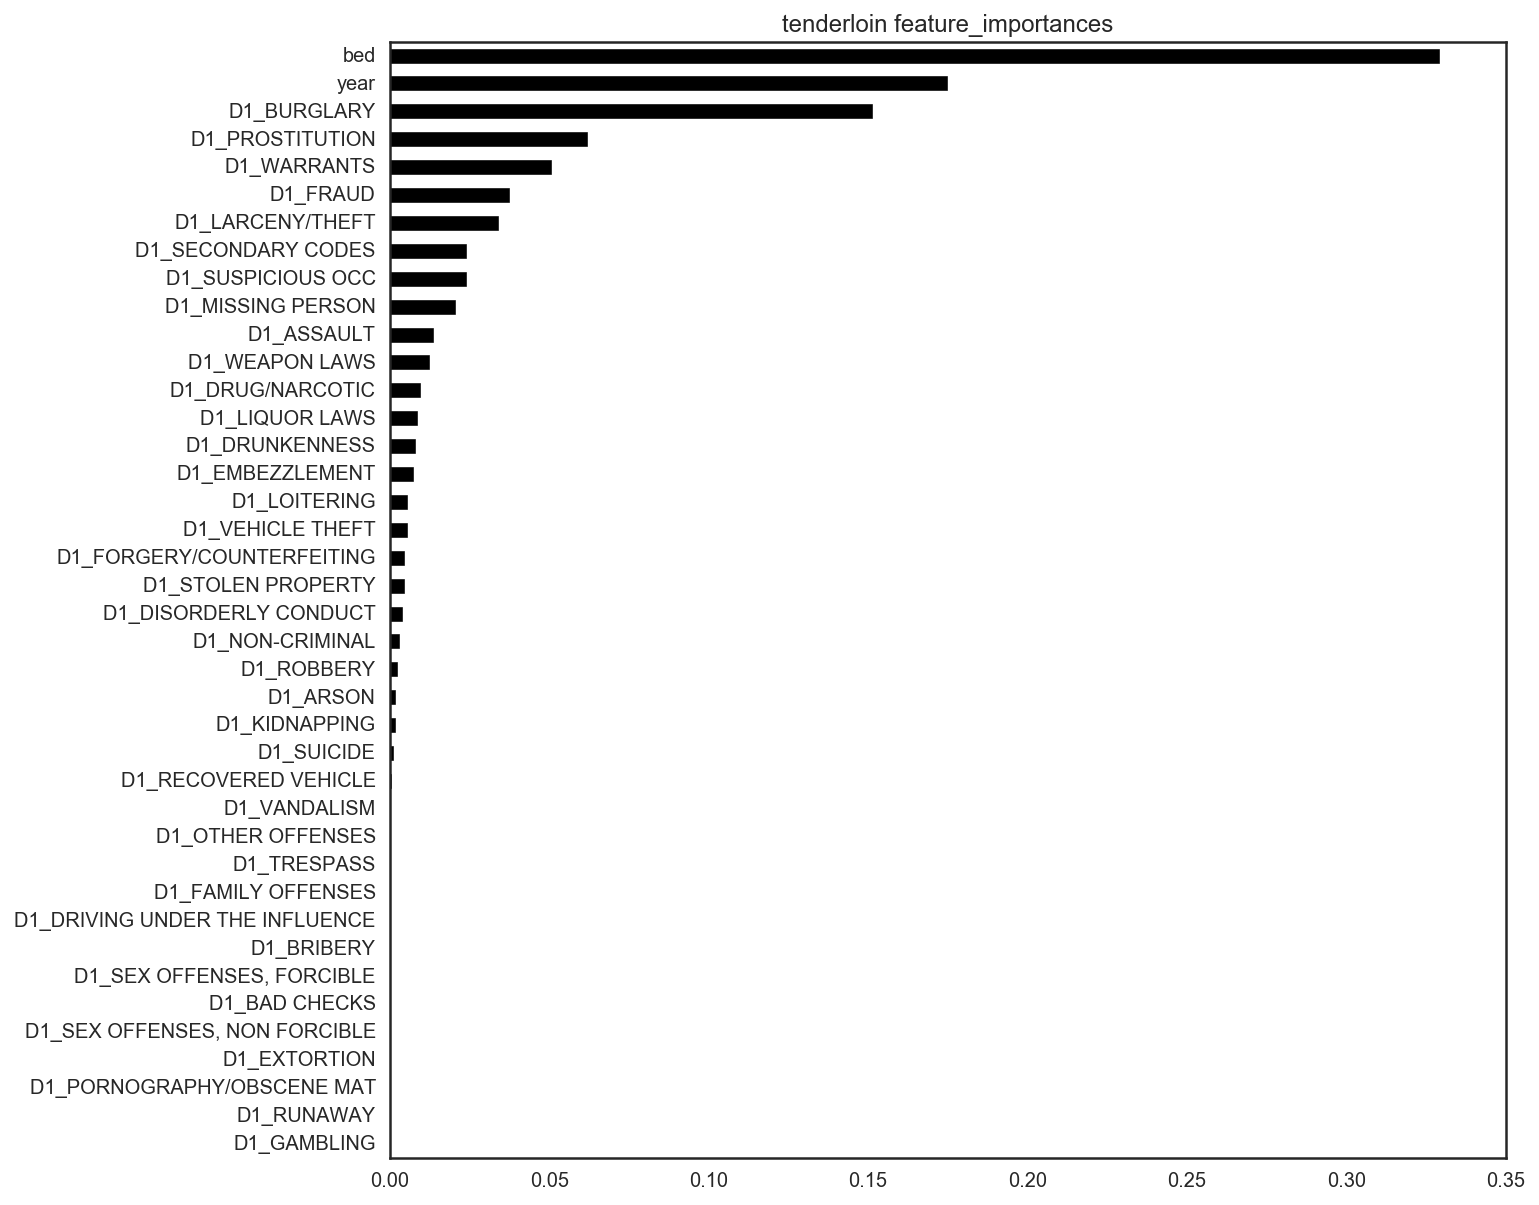

In [77]:
for index,i in enumerate(['mission district','south of market','marina','russian hill','north beach','tenderloin']):
    plt.figure(index)
    features_df_sub = features_df[i].sort_values()
    sns.set_style('white')
    features_df_sub.plot(kind = 'barh',title = i +' feature_importances', color = 'black')
    print i

## Mapping:

In [86]:
map_choro = pd.read_csv('/Users/Stav/Downloads/new_geoms_2.csv')

from branca.colormap import linear

colormap = linear.YlOrRd.scale(
    1000,3500)
    #map_choro.price.max())

price_dict = {}
for k,v in zip(map_choro['district1'],map_choro['price']):
    price_dict[k] = v
    
color_dict = {key: colormap(price_dict[key]) for key in price_dict.keys()}
color_dict

{'bayview': '#fec863',
 'bernal heights': '#fea747',
 'castro/upper market': '#feb54f',
 'chinatown': '#ffe98e',
 'diamond heights': '#e9251f',
 'downtown/civic center': '#feb650',
 'excelsior': '#fff6a4',
 'financial district': '#b20026',
 'glen park': '#fe9640',
 'golden gate park': '#feae4a',
 'haight ashbury': '#feb852',
 'inner richmond': '#fec15b',
 'inner sunset': '#b10026',
 'lakeshore': '#fe923e',
 'marina': '#fe9a42',
 'mission district': '#fea847',
 'nob hill': '#feb54f',
 'noe valley': '#fe943f',
 'north beach': '#fd853a',
 'ocean view': '#fea345',
 'outer mission': '#fec35e',
 'outer richmond': '#fed673',
 'outer sunset': '#febf59',
 'pacific heights': '#fd582d',
 'parkside': '#cf0f20',
 'potrero hill': '#fd6831',
 'presidio': '#fd7635',
 'presidio heights': '#f13723',
 'russian hill': '#fd7e37',
 'seacliff': '#fec35e',
 'south of market': '#b10026',
 'twin peaks': '#fea245',
 'visitacion valley': '#fd7f38',
 'west of twin peaks': '#febf59',
 'western addition': '#ffdb79'}

In [89]:

from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://stavgrossfeld.cartodb.com/viz/f411c652-3cdf-11e6-8073-0ecfd53eb7d3/embed_map" \
     allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')
from folium.map import Popup, Icon, Marker
import folium
from folium import plugins

crime_sub_map = crime_sub
crime_sub_map['Date'] = crime_sub.index

#Cartodb Dark_matter
m = folium.Map(location=[37.7599,-122.431297],tiles='Cartodb Dark_matter', zoom_start = 12, min_zoom = 12, max_zoom = 15)

folium.GeoJson(open('/Users/Stav/Downloads/new_geoms_2.geojson'),style_function=lambda feature:{'fillColor': color_dict[feature['properties']['district1']],'fillOpacity':'.5','color' : 'white','weight':'3','dashArray':'5,5'}).add_to(m)

marker_cluster = folium.MarkerCluster("Theft").add_to(m)

for each in crime_sub_map[crime_sub_map['is_theft']==1][0:1000].iterrows():
    #print each[1]['Category'], each[1]['DayOfWeek'], each['Time']
    popup = str('crime: ' + each[1]['Category'] + '\n' + 'date: ' + str(each[1]['Date']).split()[0] + '\n'  'day: '  + each[1]['DayOfWeek'] + '\n' + 'time: ' + each[1]['Time'])
    folium.Marker(location = [each[1]['Y'],each[1]['X']],popup=popup).add_to(marker_cluster)
    
    
    
    

print colormap
m
# display(HTML("""
# <div style="position: absolute">
#     <div id='legend-form'>
#         <h4>rental price</h4>
#            <select name="something">
#                <option>price</option>
#                <option>crime</option>
#            </select>
#     </div>
# </div>
# """))





In [91]:
colormap

In [116]:

from folium.map import Popup, Icon, Marker
import folium
from folium import plugins

from IPython.display import clear_output
from ipywidgets import *
from IPython.display import display



hello = [i for i in crime_sub.Category.unique()]


from ipywidgets import Dropdown


crime = Dropdown(
   options= hello,
   value = hello[0],
   description='Crimes: ',
)



submit_button = Button(description="Submit Info")
submit_button.on_click(test)  # test is my mapping function

display(crime)
display(submit_button)

def test(crime_sub):
    clear_output()
    print crime.value
    crime_select = crime_sub_map[crime_sub_map.Category == crime.value]
    
    select_map = folium.Map(location=[37.7599,-122.431297],tiles='Cartodb Dark_matter', zoom_start = 12, min_zoom = 12, max_zoom = 15)

    folium.GeoJson(open('/Users/Stav/Downloads/new_geoms_2.geojson'),style_function=lambda feature:{'fillColor': color_dict[feature['properties']['district1']],'fillOpacity':'.5','color' : 'white','weight':'3','dashArray':'5,5'}).add_to(select_map)

    marker_cluster = folium.MarkerCluster("select").add_to(select_map)

    for each in crime_select[0:1000].iterrows():
        #print each[1]['Category'], each[1]['DayOfWeek'], each['Time']
        popup = str('crime: ' + each[1]['Category'] + '\n' + 'date: ' + str(each[1]['Date']).split()[0] + '\n'  'day: '  + each[1]['DayOfWeek'] + '\n' + 'time: ' + each[1]['Time'])
        folium.Marker(location = [each[1]['Y'],each[1]['X']],popup=popup).add_to(marker_cluster)
    clear_output()
    display(select_map)
    display(colormap)


    clear_output
# after they submit destination.values